In [ ]:
"""
Domain
    SEA Transportation

focus
    forecast demand

Business challenge/requirement
    SeaPort is the largest operator of Sea Planes across sea shores in Europe. SeaPort 
    doesn't have planes of their own, rather they lease them on a short-term basis based 
    on passenger traffic.
    You as an ML expert have to build a model to forecast the demand (passenger traffic) 
    of traffic. 

Key issues
    As of now, utilization of Planes is low due to poor forecasts of traffic

Considerations
    NONE

Data volume
    - Approx 144 records - data month-wise for last 12 years - file SeaPlaneTravel.csv 

Fields in Data
    • Month: Month in which traffic data was recorded 
    • '#Passenger': No of travelers availing Service in that month

Additional information
    - NA

Business benefits
    Better utilization of planes will lead to a decrease in cost and hence better bottom line
"""

In [51]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

In [28]:
warnings.filterwarnings(action='ignore')

In [29]:
CSV_PATH = r'D:\CourseWork\data-science-python-certification-course\Assignments\13 Time Series Analysis\Case Study\resources\SeaPlaneTravel.csv'
data = pd.read_csv(CSV_PATH)
data.head(5)

,Month,#Passengers
0,2003-01,112
1,2003-02,118
2,2003-03,132
3,2003-04,129
4,2003-05,121


In [30]:
data['Month'] = pd.to_datetime(data['Month'])
indexed_df = data.set_index('Month')
ts = indexed_df['#Passengers']
ts.head(5)

Month
2003-01-01    112
2003-02-01    118
2003-03-01    132
2003-04-01    129
2003-05-01    121
Name: #Passengers, dtype: int64

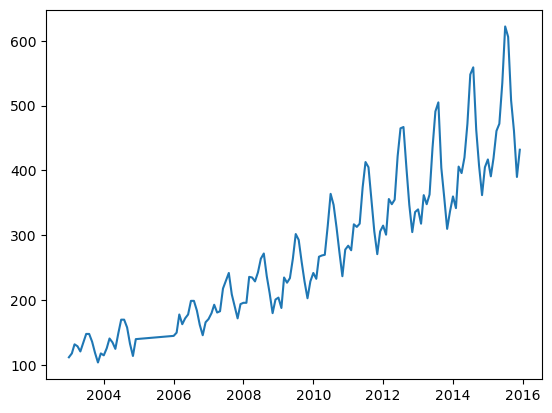

In [31]:
plt.plot(ts)
plt.show()

In [32]:
def test_stationarity(timeseries):
    
    # Determining rolling statistics
    rolmean = timeseries.rolling(window=12, center=False).mean()
    rolstd = timeseries.rolling(window=12, center=False).std()

    # Plot rolling statistics:
    plt.plot(timeseries, color='blue', label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

    # Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(
        dftest[0:4], 
        index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
        
    print(dfoutput)

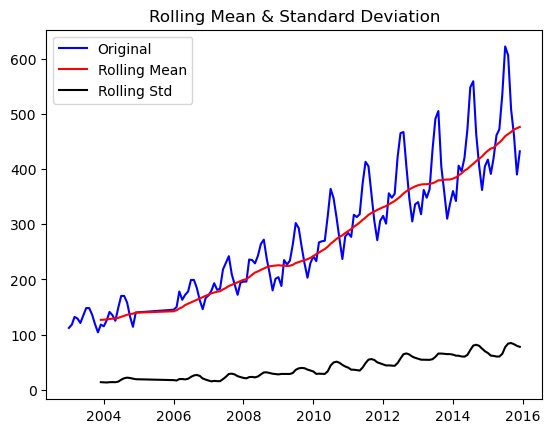

Results of Dickey-Fuller Test:
Test Statistic                   0.815369
p-value                          0.991880
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64


In [33]:
test_stationarity(ts)

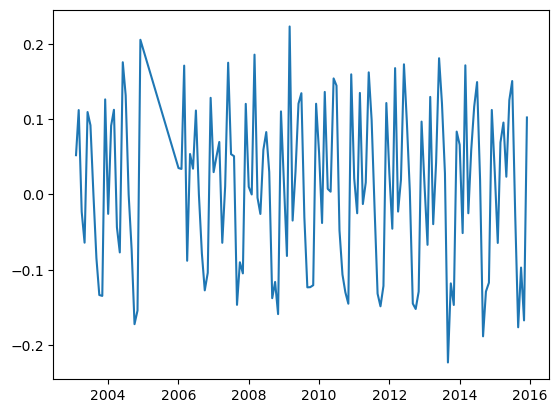

In [34]:
ts_log = np.log(ts)
ts_log_diff = ts_log - ts_log.shift()
plt.plot(ts_log_diff)

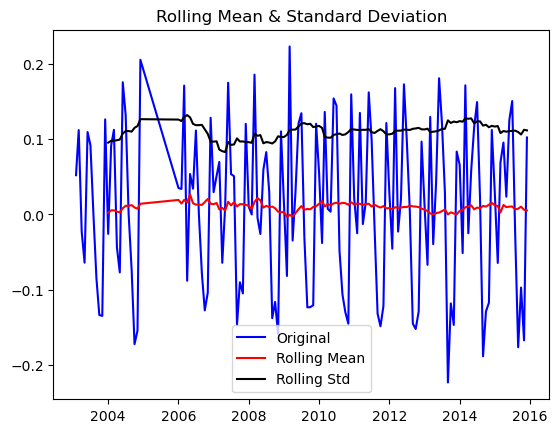

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64


In [35]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

In [36]:
lag_acf = acf(ts_log_diff, nlags=10)
lag_pacf = pacf(ts_log_diff, nlags=10, method='ols')

Text(0.5, 1.0, 'Autocorrelation Function')

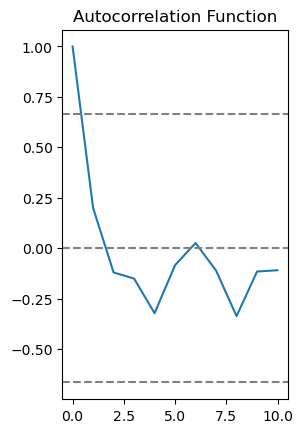

In [37]:
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Autocorrelation Function')

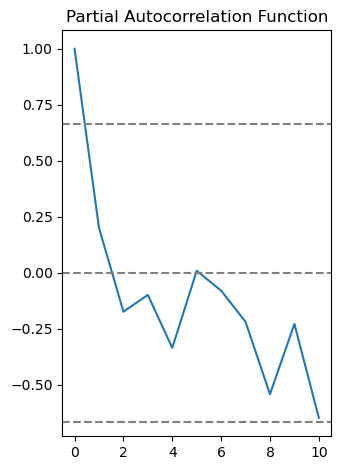

In [38]:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-7.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.axhline(y=7.96/np.sqrt(len(ts_log_diff)), linestyle='--', color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

Text(0.5, 1.0, 'RSS: nan')

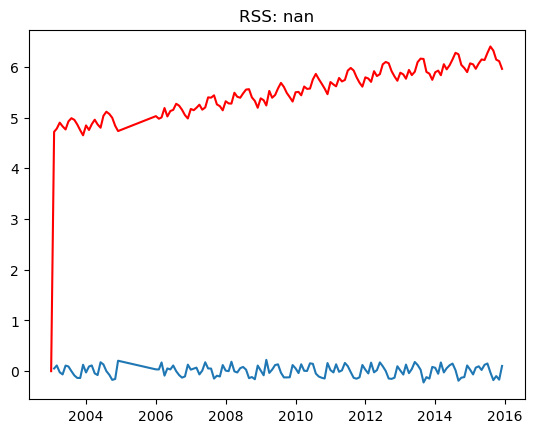

In [39]:
model = ARIMA(ts_log, order=(2, 1, 1))
results_ARIMA = model.fit()
plt.plot(ts_log_diff)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.4f' % sum((results_ARIMA.fittedvalues-ts_log_diff)**2))

In [40]:
print(results_ARIMA.summary())

                               SARIMAX Results                                
Dep. Variable:            #Passengers   No. Observations:                  144
Model:                 ARIMA(2, 1, 1)   Log Likelihood                 129.732
Date:                Fri, 25 Aug 2023   AIC                           -251.464
Time:                        09:05:07   BIC                           -239.612
Sample:                             0   HQIC                          -246.648
                                - 144                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9792      0.100      9.839      0.000       0.784       1.174
ar.L2         -0.3740      0.118     -3.177      0.001      -0.605      -0.143
ma.L1         -0.8303      0.102     -8.118      0.0

                0
count  144.000000
mean     0.055377
std      0.402652
min     -0.153303
25%     -0.055390
50%      0.011022
75%      0.102740
max      4.718499


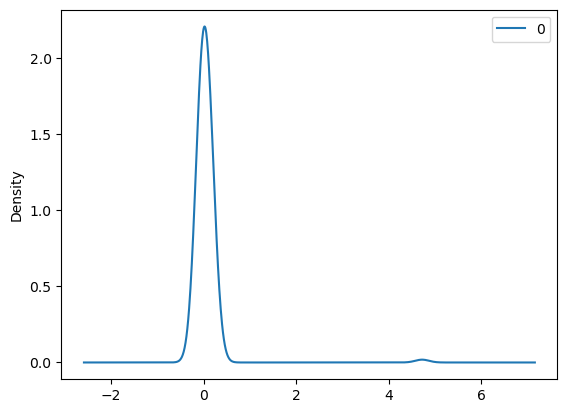

In [42]:
# plot residual errors
residuals = pd.DataFrame(results_ARIMA.resid)
residuals.plot(kind='kde')
print(residuals.describe())

In [43]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff.head())

Month
2003-01-01    0.000000
2003-02-01    4.718499
2003-03-01    4.781493
2003-04-01    4.899545
2003-05-01    4.825728
dtype: float64


Text(0.5, 1.0, 'RMSE: inf')

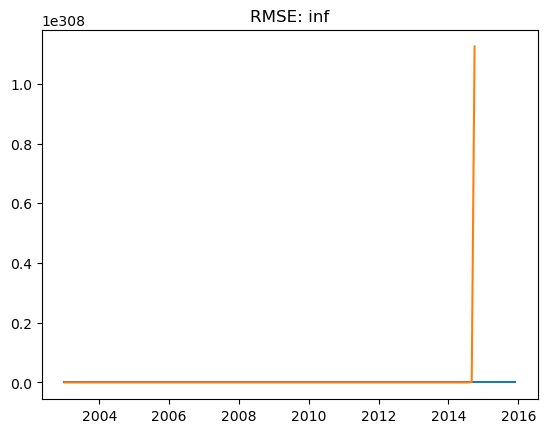

In [45]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(ts_log.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(
    predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(ts)
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f' % np.sqrt(sum((predictions_ARIMA-ts)**2)/len(ts)))

In [46]:
size = int(len(ts_log) - 15)
train, test = ts_log[0:size], ts_log[size:len(ts_log)]
history = [x for x in train]
predictions = list()

In [49]:
size = int(len(ts_log) - 15)
train, test = ts_log[0:size], ts_log[size:len(ts_log)]
history = [x for x in train]
predictions = list()
print('Printing Predicted vs Expected Values...')
for t in range(len(test)):
    model = ARIMA(history, order=(2, 1, 1))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
print('predicted=%f, expected=%f' % (np.exp(yhat), np.exp(obs)))

Printing Predicted vs Expected Values...
predicted=386.206270, expected=432.000000


In [52]:
error = mean_squared_error(test, predictions)
print('Printing Mean Squared Error of Predictions...')
print('Test MSE: %.6f' % error)
predictions_series = pd.Series(predictions, index=test.index)

Printing Mean Squared Error of Predictions...
Test MSE: 0.008601


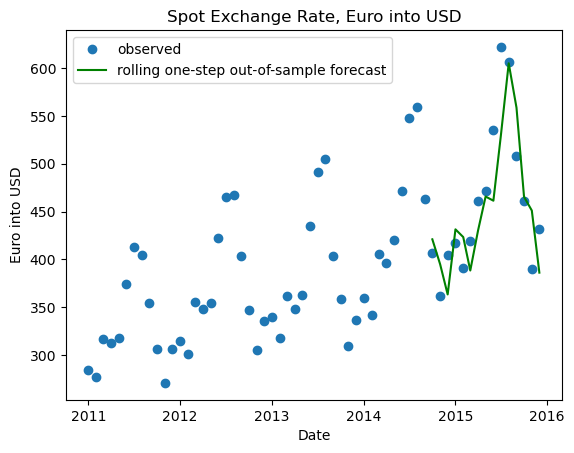

In [53]:
fig, ax = plt.subplots()
ax.set(title='Spot Exchange Rate, Euro into USD', xlabel='Date', ylabel='Euro into USD')
ax.plot(ts[-60:], 'o', label='observed')
ax.plot(np.exp(predictions_series), 'g', label='rolling one-step out-of-sample forecast')
legend = ax.legend(loc='upper left')
legend.get_frame().set_facecolor('w')